In [8]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [9]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/multiscale_entropy/c2f_calculated_entropy/renyi_data.csv',header=None)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142 entries, 0 to 1141
Columns: 191 entries, 0 to 190
dtypes: float64(190), int64(1)
memory usage: 1.7 MB


In [11]:
import numpy as np
y = df[df.shape[1]-1].values
df = df.dropna(axis=1, how='all')
df=df.replace([np.inf, -np.inf], np.nan)

df=df.T.fillna(df.mean(axis=1)).T


In [12]:
df.shape

(1142, 191)

In [13]:

cols_to_scale = list(df.columns)[:-1]
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
scaler = StandardScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])


In [14]:
X = df.drop([df.shape[1]-1], axis=1)

In [15]:
from collections import Counter
print(Counter(y))

Counter({2: 626, 1: 516})


In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train,y_train)
print(logreg.score(X_test,y_test))
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(y_test,logreg.predict(X_test)))

0.7816593886462883
              precision    recall  f1-score   support

           1       0.75      0.77      0.76       104
           2       0.80      0.79      0.80       125

    accuracy                           0.78       229
   macro avg       0.78      0.78      0.78       229
weighted avg       0.78      0.78      0.78       229



svm

In [19]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear')
svm.fit(X_train,y_train)
svm.score(X_test,y_test)

0.7467248908296943

In [20]:
print(classification_report(y_test,svm.predict(X_test)))

              precision    recall  f1-score   support

           1       0.73      0.71      0.72       104
           2       0.76      0.78      0.77       125

    accuracy                           0.75       229
   macro avg       0.74      0.74      0.74       229
weighted avg       0.75      0.75      0.75       229



# New Section

In [21]:
'''Set a seed for reproducibility'''
seed = 43

'''Initialize all the regression models object we are interested in.'''
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

'''We are interested in the following 14 regression models.
All initialized with default parameters except random_state and n_jobs.'''


et = ExtraTreesClassifier(n_jobs = -1, random_state = seed)
ab = AdaBoostClassifier(random_state = seed)
gb = GradientBoostingClassifier(random_state = seed)
xgb = XGBClassifier(random_state = seed, n_jobs = -1)
lgb = LGBMClassifier(random_state = seed, n_jobs = -1)

knn = KNeighborsClassifier(3)
lsvm = SVC(kernel="linear", C=0.025)
rsvm = SVC(kernel="rbf",gamma=2, C=1)
gps = GaussianProcessClassifier(1.0 * RBF(1.0))
dt = DecisionTreeClassifier(max_depth=5)
rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
mlp = MLPClassifier(alpha=1, max_iter=1000)
gnb = GaussianNB()
qda = QuadraticDiscriminantAnalysis()

In [22]:
'''Evaluate models on the holdout set(say on 30%).'''
def train_test_split_score(model):
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)
    model.fit(X_train, Y_train)
    return model.score(X_test,Y_test)
'''Calculate train_test_split score of differnt models and plot them.'''
models = [et,ab,gb,xgb,lgb,knn,lsvm,rsvm,gps,dt,rf,mlp,gnb,qda]
train_test_split_res = []
for model in models:
    train_test_split_res.append(train_test_split_score(model))

'''Plot data frame of train test rmse'''
train_test_score = pd.DataFrame(data = train_test_split_res, columns = ['Train_Test_SCORE'])
train_test_score.index = ['ET', 'AB', 'GB', 'XGB', 'LGB', 'KNN', 'LSVM', 'RSVM', 'GPS', 'DT', 'RF', 'MLP', 'GNB', 'QDA']
train_test_score = train_test_score.round(5)
train_test_score

,Train_Test_SCORE
ET,0.79476
AB,0.73362
GB,0.78166
XGB,0.81223
LGB,0.79039
KNN,0.80349
LSVM,0.69869
RSVM,0.55459
GPS,0.79913
DT,0.68122


In [23]:
def cross_validate(model):
    from sklearn.model_selection import cross_val_score
    score = cross_val_score(model, X, y, cv = 10, n_jobs = -1, scoring = 'accuracy')
    return score.mean()

'''Calculate cross validation score of differnt models and plot them.'''
models = [et,ab,gb,xgb,lgb,knn,lsvm,rsvm,gps,dt,rf,mlp,gnb,qda]
cross_val_scores = []
for model in models:
    cross_val_scores.append(cross_validate(model))

'''Plot data frame of cross validation scores.'''
x_val_score = pd.DataFrame(data = cross_val_scores, columns = ['Cross Validation Scores (ACC)'])
x_val_score.index = ['ET', 'AB', 'GB', 'XGB', 'LGB', 'KNN', 'LSVM', 'RSVM', 'GPS', 'DT', 'RF', 'MLP', 'GNB', 'QDA']

In [24]:
x_val_score

,Cross Validation Scores (ACC)
ET,0.724409
AB,0.650031
GB,0.701617
XGB,0.719161
LGB,0.713852
KNN,0.683196
LSVM,0.624462
RSVM,0.548162
GPS,0.626156
DT,0.698986


In [25]:
'''Create a function to plot learning curves.'''
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(model):
    from sklearn.model_selection import learning_curve
    
    # df_train_final is training matrix and y_train is target matrix.
    # Create CV training and test scores for various training set sizes
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, 
                                            train_sizes = np.linspace(0.01, 1.0, 20), cv = 10, scoring = 'accuracy', 
                                            n_jobs = -1, random_state = seed)
    
    
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)  
    # Draw lines
    plt.plot(train_sizes, train_mean, 'o-', color = 'red',  label = 'Training score')
    plt.plot(train_sizes, test_mean, 'o-', color = 'green', label = 'Cross-validation score')
    
    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha = 0.1, color = 'r') # Alpha controls band transparency.
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha = 0.1, color = 'g')
    
    
    # Create plot
    font_size = 12
    plt.xlabel('Training Set Size', fontsize = font_size)
    plt.ylabel('Accuracy Score', fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.legend(loc = 'best')
    plt.grid()

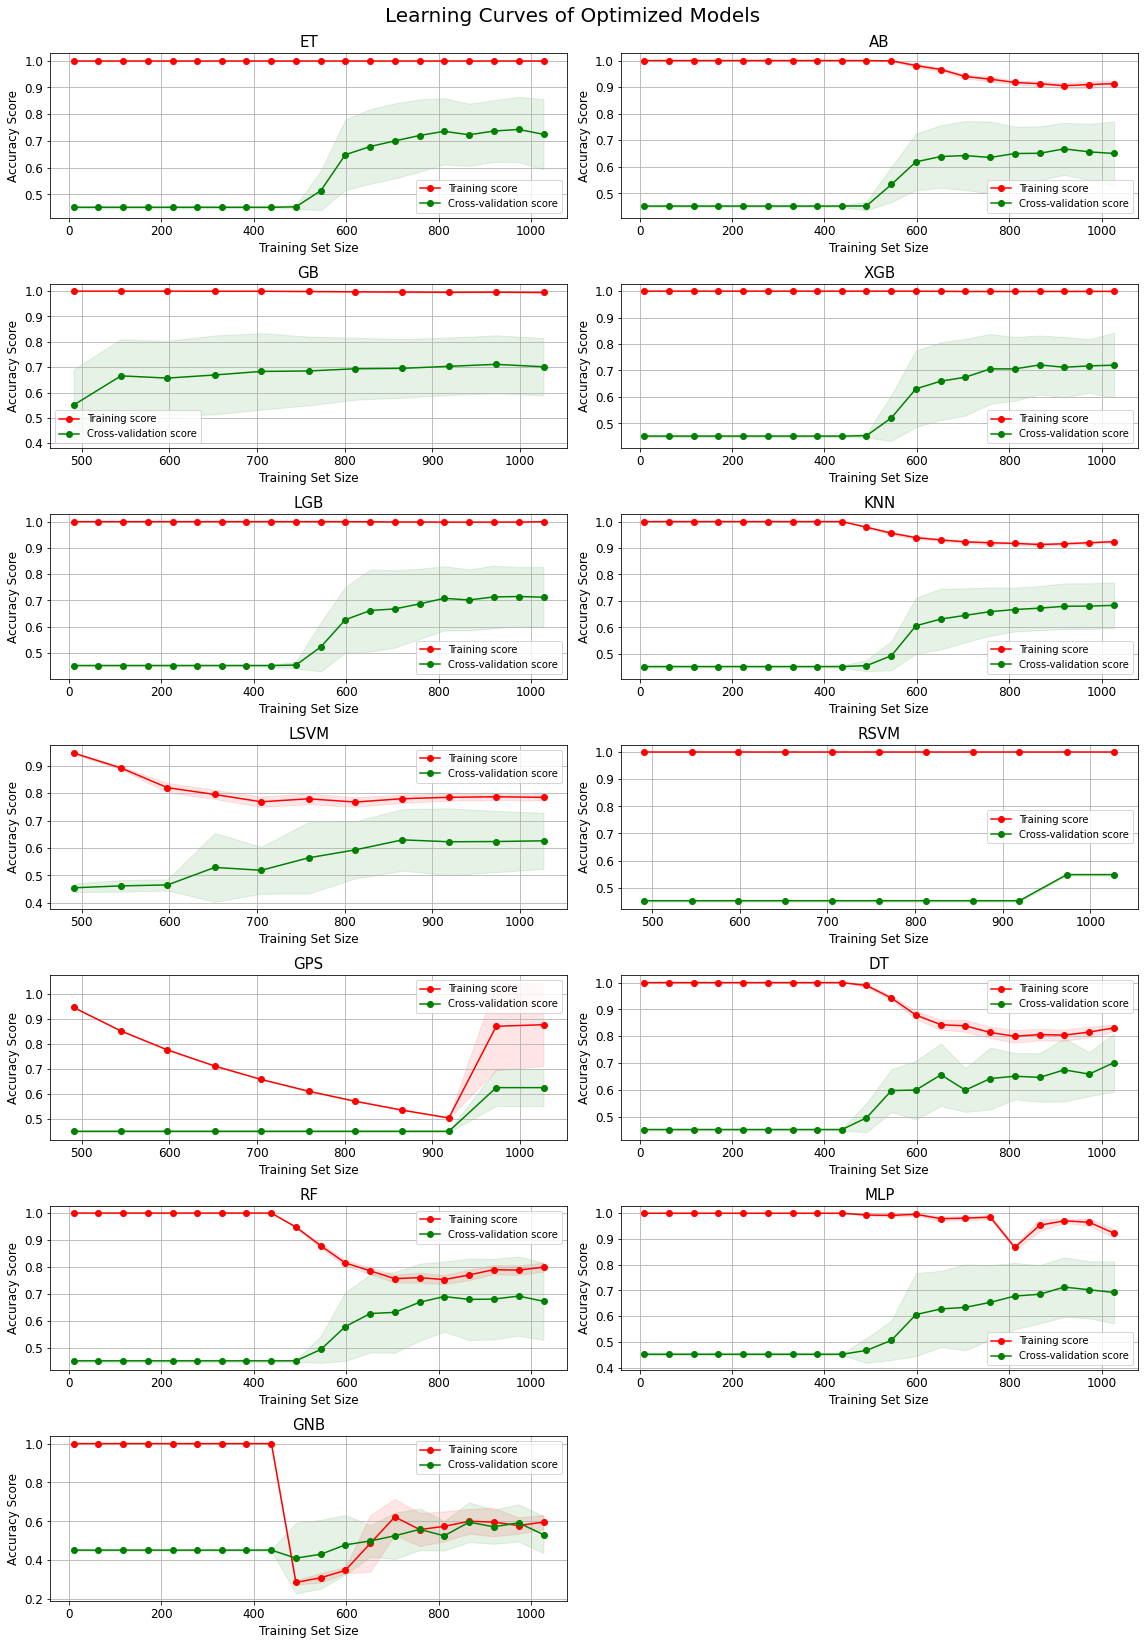

In [26]:
'''Now plot learning curves of the optimized models in subplots.
For computational reason, I am omitting XGB, GB, and LGB.'''
plt.figure(figsize = (16,24))
lc_models = [et,ab,gb,xgb,lgb,knn,lsvm,rsvm,gps,dt,rf,mlp,gnb,qda]
lc_labels = ['ET', 'AB', 'GB', 'XGB', 'LGB', 'KNN', 'LSVM', 'RSVM', 'GPS', 'DT', 'RF', 'MLP', 'GNB', 'QDA']

for ax, models, labels in zip (range(1,14), lc_models, lc_labels):
    try:
        plt.subplot(7,2,ax)
        plot_learning_curve(models)
        plt.title(labels, fontsize = 15)
    except:
        pass
plt.suptitle('Learning Curves of Optimized Models', fontsize = 20)
plt.tight_layout(rect = [0, 0.03, 1, 0.97])

# XGB

In [27]:
import xgboost as xgb
# read in data
'''
dtrain = xgb.DMatrix(X_train,y_train)
dtest = xgb.DMatrix(X_test,y_test)
evallist = [(dtest, 'eval'), (dtrain, 'train')]
# specify parameters via map
param = {'booster': 'dart',
         'max_depth': 5, 'learning_rate': 0.01,
         'objective': 'binary:logistic',
         'sample_type': 'uniform',
         'normalize_type': 'tree',
         'rate_drop': 0.1,
         'eval_metric':'auc',
         'skip_drop': 0.5}
num_round = 500
bst = xgb.train(param, dtrain, num_round,evallist)
preds = bst.predict(dtest)
'''

"\ndtrain = xgb.DMatrix(X_train,y_train)\ndtest = xgb.DMatrix(X_test,y_test)\nevallist = [(dtest, 'eval'), (dtrain, 'train')]\n# specify parameters via map\nparam = {'booster': 'dart',\n         'max_depth': 5, 'learning_rate': 0.01,\n         'objective': 'binary:logistic',\n         'sample_type': 'uniform',\n         'normalize_type': 'tree',\n         'rate_drop': 0.1,\n         'eval_metric':'auc',\n         'skip_drop': 0.5}\nnum_round = 500\nbst = xgb.train(param, dtrain, num_round,evallist)\npreds = bst.predict(dtest)\n"

In [28]:
#xgb.plot_importance(bst)

In [29]:
param = {'booster': 'dart',
         'max_depth': 5,
         'learning_rate': 0.001,
         'objective': 'binary:logistic',
         'sample_type': 'uniform',
         'normalize_type': 'tree',
         'rate_drop': 0.1,
         'skip_drop': 0.5,
         'n_estimators':2000}

[0]	validation_0-logloss:0.69265	validation_0-auc:0.90090	validation_1-logloss:0.69283	validation_1-auc:0.76962
[1]	validation_0-logloss:0.69215	validation_0-auc:0.90090	validation_1-logloss:0.69250	validation_1-auc:0.77038
[2]	validation_0-logloss:0.69166	validation_0-auc:0.90077	validation_1-logloss:0.69218	validation_1-auc:0.77108
[3]	validation_0-logloss:0.69116	validation_0-auc:0.90070	validation_1-logloss:0.69186	validation_1-auc:0.77131
[4]	validation_0-logloss:0.69067	validation_0-auc:0.90070	validation_1-logloss:0.69154	validation_1-auc:0.77131
[5]	validation_0-logloss:0.69018	validation_0-auc:0.90070	validation_1-logloss:0.69122	validation_1-auc:0.77131
[6]	validation_0-logloss:0.68969	validation_0-auc:0.90070	validation_1-logloss:0.69090	validation_1-auc:0.77131
[7]	validation_0-logloss:0.68920	validation_0-auc:0.90070	validation_1-logloss:0.69059	validation_1-auc:0.77131
[8]	validation_0-logloss:0.68871	validation_0-auc:0.90070	validation_1-logloss:0.69027	validation_1-auc:

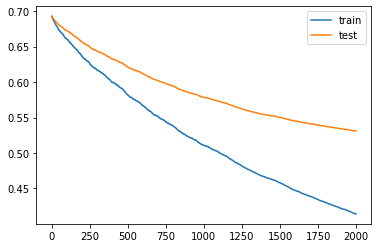

In [30]:
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from matplotlib import pyplot
# define the model
model = XGBClassifier(**param)
# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]
# fit the model
model.fit(X_train, y_train, eval_metric=['logloss','auc'], eval_set=evalset)
# evaluate performance
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

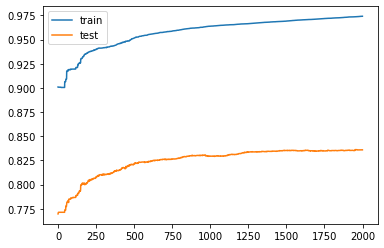

In [31]:
# plot learning curves
pyplot.plot(results['validation_0']['auc'], label='train')
pyplot.plot(results['validation_1']['auc'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [32]:
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           1       0.72      0.77      0.74       104
           2       0.80      0.75      0.77       125

    accuracy                           0.76       229
   macro avg       0.76      0.76      0.76       229
weighted avg       0.76      0.76      0.76       229



In [33]:
print(confusion_matrix(y_test,model.predict(X_test)))

[[80 24]
 [31 94]]


# Lazy prediction

In [34]:
#!pip install lazypredict


In [35]:
import lazypredict
### importing LazyClassifier for classification problem
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric = None)
### fitting data in LazyClassifier
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
### lets check which model did better on Breast Cancer Dataset
print(models)

100%|██████████| 29/29 [00:09<00:00,  2.98it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.85               0.85     0.85      0.85   
RandomForestClassifier             0.83               0.83     0.83      0.83   
LGBMClassifier                     0.82               0.82     0.82      0.82   
XGBClassifier                      0.81               0.81     0.81      0.81   
NuSVC                              0.80               0.80     0.80      0.80   
KNeighborsClassifier               0.79               0.79     0.79      0.79   
LogisticRegression                 0.78               0.78     0.78      0.78   
SVC                                0.77               0.78     0.78      0.77   
RidgeClassifierCV                  0.77               0.77     0.77      0.77   
LinearSVC                          0.77               0.77     0.77      0.77   
BaggingClassifier           

In [35]:
predictions